In [86]:
import os
import sys
import json
import io
import hashlib

import numpy as np

import pandas as pd

## Load and process data 

In [2]:
coco_image_dir = '/home/david/datasets/coco/val2017/images/'
coco_annotations_filepath = '/home/david/datasets/coco/val2017/annotations/instances_val2017.json'

In [3]:
# Load raw data from disk
with open(coco_annotations_filepath, 'r') as fp:
    val_instances = json.load(fp)

In [4]:
# Load annotation info into dataframe
# box coordinates [x,y,width,height] are measured from the top left image corner and are 0-indexed
df_ann = (
    pd.DataFrame(val_instances['annotations'])
    .drop(columns=['segmentation', 'area'])
    .rename(columns={'id': 'instance_id'})
)

# Load category info into dataframe
df_cat = (
    pd.DataFrame(val_instances['categories'])
    .drop(columns=['supercategory'])
    .rename(columns={'id': 'category_id', 'name': 'category_name'})
)
df_cat['category_name_orig'] = df_cat['category_name']
df_cat['category_name'] = df_cat['category_name'].str.lower().str.replace(' ', '_')

# Load image info
df_image = pd.DataFrame(val_instances['images']).rename(columns={'id': 'image_id'})
df_image['image_filepath'] = df_image['file_name'].apply(lambda x: os.path.join(coco_image_dir, x))
df_image.drop(columns=['license', 'file_name', 'coco_url', 'date_captured', 'flickr_url'], inplace=True)

# Combine all info into single dataframe
df_comb = pd.merge(df_ann, df_cat, on='category_id', how='left')
df_comb = pd.merge(df_comb, df_image, on='image_id', how='left')

In [5]:
# Convert bounding boxes to normalized coordinates
df_comb['wmin'] = df_comb['bbox'].str[0] / df_comb['width']
df_comb['hmin'] = df_comb['bbox'].str[1] / df_comb['height']
df_comb['wmax'] = (df_comb['bbox'].str[0] + df_comb['bbox'].str[2]) / df_comb['width']
df_comb['hmax'] = (df_comb['bbox'].str[1] + df_comb['bbox'].str[3]) / df_comb['height']

## Visualize bounding boxes 

In [6]:
import PIL.Image as Image
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont


def draw_bounding_box_on_image(image,
                               ymin, xmin, ymax, xmax,
                               color='red',
                               thickness=4,
                               display_str_list=(),
                               use_normalized_coordinates=True):
    """Adds a bounding box to an image.
    
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.
    Each string in display_str_list is displayed on a separate line above the
    bounding box in black text on a rectangle filled with the input 'color'.
    If the top of the bounding box extends to the edge of the image, the strings
    are displayed below the bounding box.
    
    Args:
        image: a PIL.Image object.
        ymin: ymin of bounding box.
        xmin: xmin of bounding box.
        ymax: ymax of bounding box.
        xmax: xmax of bounding box.
        color: color to draw bounding box. Default is red.
        thickness: line thickness. Default value is 4.
        display_str_list: list of strings to display in box
            (each to be shown on its own line).
        use_normalized_coordinates: If True (default), treat coordinates
            ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
            coordinates as absolute.
    """
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        (left, right, top, bottom) = (xmin*im_width, xmax*im_width, ymin*im_height, ymax*im_height)
    else:
        (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    if thickness > 0:
        draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
                  width=thickness,
                  fill=color)
    try:
        font = ImageFont.truetype('arial.ttf', 24)
    except IOError:
        font = ImageFont.load_default()

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle(
            [(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)],
            fill=color)
        draw.text(
            (left + margin, text_bottom - text_height - margin),
            display_str,
            fill='black',
            font=font)
        text_bottom -= text_height - 2 * margin


def draw_bounding_boxes_on_image(image,
                                 boxes,
                                 color='red',
                                 thickness=4,
                                 display_str_list_list=()):
    """Draws bounding boxes on image.
    
    Args:
        image: a PIL.Image object.
        boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax). 
            The coordinates are in normalized format between [0, 1].
        color: color to draw bounding box. Default is red.
        thickness: line thickness. Default value is 4.
        display_str_list_list: list of list of strings. 
            A list of strings for each bounding box. The reason to pass a list of 
            strings for a bounding box is that it might contain multiple labels.

    Raises:
        ValueError: if boxes is not a [N, 4] array
    """
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        display_str_list = ()
        if display_str_list_list:
            display_str_list = display_str_list_list[i]
        draw_bounding_box_on_image(image, boxes[i, 0], boxes[i, 1], boxes[i, 2], boxes[i, 3], 
                                   color, thickness, display_str_list)

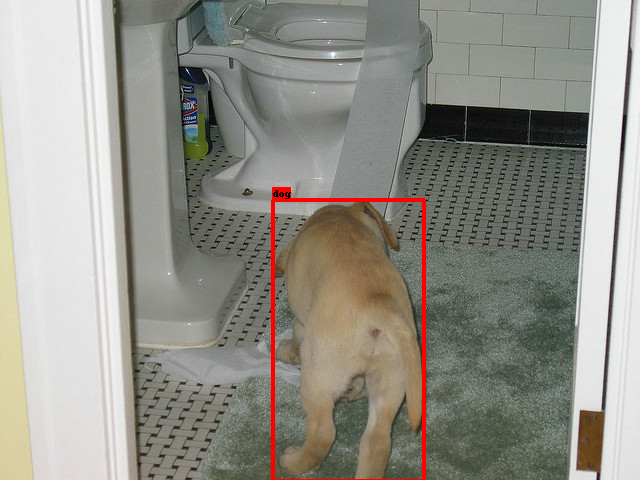

In [7]:
ind = 1

filepath = df_comb.iloc[ind]['image_filepath']
ymin, xmin, ymax, xmax = df_comb.iloc[ind][['hmin', 'wmin', 'hmax', 'wmax']]
label = df_comb.iloc[ind]['category_name']
img = Image.open(filepath)
draw_bounding_box_on_image(img, ymin, xmin, ymax, xmax, display_str_list=(label,))
img

In [ ]:
ind = 0

image_grps = df_comb.groupby('image_filepath')
image_filepaths = list(image_grps.groups.keys())
image_filepath = image_filepaths[ind]
df_image_grp = image_grps.get_group(image_filepath)
bboxes = df_image_grp[['hmin', 'wmin', 'hmax', 'wmax']].values
labels = [(nm,) for nm in df_image_grp['category_name']]
img = Image.open(image_filepath)
draw_bounding_boxes_on_image(img, bboxes, display_str_list_list=labels)
img

## Create datasets 

In [8]:
# Choose categories to consider, implicitly indicating which should have missing instances
dataset1_cats = {'person', 'car', 'book', 'cup', 'dining_table'}
dataset2_cats = {'person', 'chair', 'bottle', 'cup', 'dining_table'}
dataset3_cats = dataset1_cats | dataset2_cats

# Assign images to differnet halves of dataset with missing annotations
np.random.seed(0)
image_ids = df_comb['image_id'].unique()
image_id_dataset_mask = np.random.randint(0, 2, len(image_ids)).astype(bool)
image_ids_dataset1 = set(image_ids[image_id_dataset_mask].tolist())
image_ids_dataset2 = set(image_ids[~image_id_dataset_mask].tolist())
is_dataset1_image = df_comb['image_id'].isin(image_ids_dataset1)
is_dataset2_image = df_comb['image_id'].isin(image_ids_dataset2)

# Identify instances belonging to valid categories
is_dataset1_cat = df_comb['category_name'].isin(dataset1_cats)
is_dataset2_cat = df_comb['category_name'].isin(dataset2_cats)
is_dataset3_cat = df_comb['category_name'].isin(dataset3_cats)

# Identify valid instances for two halves of dataset with partial annotations
is_dataset1_instance = is_dataset1_image & is_dataset1_cat
is_dataset2_instance = is_dataset2_image & is_dataset2_cat
is_dataset12_instance = is_dataset1_instance | is_dataset2_instance

# Identify valid instances for dataset with complete annotations
image_ids_dataset12 = set(df_comb.loc[is_dataset12_instance, 'image_id'].tolist())
is_dataset3_image = df_comb['image_id'].isin(image_ids_dataset12)
is_dataset3_instance = is_dataset3_image & is_dataset3_cat

# Create dataframes for datasets with partial and complete annotations
df_dataset12 = df_comb[is_dataset12_instance].copy()
df_dataset3 = df_comb[is_dataset3_instance].copy()

# Create new sequential label ids for retained categories
category_id_map_new = {nm: ind for ind, nm in enumerate(dataset3_cats, 1)}
df_dataset12['category_id_orig'] = df_dataset12['category_id']
df_dataset3['category_id_orig'] = df_dataset3['category_id']
df_dataset12['category_id'] = df_dataset12['category_name'].apply(lambda x: category_id_map_new[x])
df_dataset3['category_id'] = df_dataset3['category_name'].apply(lambda x: category_id_map_new[x])

In [9]:
# Get total instance and image counts
num_images1 = df_comb.loc[is_dataset1_instance, 'image_id'].nunique()
num_images2 = df_comb.loc[is_dataset2_instance, 'image_id'].nunique()
num_images3 = df_comb.loc[is_dataset3_instance, 'image_id'].nunique()
print(f'dataset 1 - num images: {num_images1}, num instances: {is_dataset1_instance.sum()}')
print(f'dataset 2 - num images: {num_images2}, num instances: {is_dataset2_instance.sum()}')
print(f'dataset 3 - num images: {num_images3}, num instances: {is_dataset3_instance.sum()}')

# Get per category instance counts 
pd.concat(
    [
        df_comb.loc[is_dataset1_instance, 'category_name'].value_counts().rename('dataset1'),
        df_comb.loc[is_dataset2_instance, 'category_name'].value_counts().rename('dataset2'),
        df_comb.loc[is_dataset3_instance, 'category_name'].value_counts().rename('dataset3'),
    ],
    axis=1
).sort_values(by='dataset3', ascending=False).astype(pd.Int64Dtype())

dataset 1 - num images: 1681, num instances: 7986
dataset 2 - num images: 1590, num instances: 7503
dataset 3 - num images: 3271, num instances: 17919


,dataset1,dataset2,dataset3
person,5630,5374,11004
chair,<NA>,802,1712
car,915,<NA>,1650
book,583,<NA>,1020
bottle,<NA>,589,937
cup,465,434,899
dining_table,393,304,697


## Split datasets into train/val/test

In [10]:
# Define split parameters
train_frac = 0.7
val_frac = 0.1
np.random.seed(0)

# Assign images to different splits
num_train = round(len(image_ids) * train_frac)
num_val = round(len(image_ids) * val_frac)
image_ids_shuffle = np.random.permutation(image_ids)
image_ids_train = set(image_ids_shuffle[:num_train].tolist())
image_ids_val = set(image_ids_shuffle[num_train:num_train+num_val].tolist())
image_ids_test = set(image_ids_shuffle[num_train+num_val:].tolist())

# Create dataframes with different splits
df_dataset12_train = df_dataset12[df_dataset12['image_id'].isin(image_ids_train)]
df_dataset12_val = df_dataset12[df_dataset12['image_id'].isin(image_ids_val)]
df_dataset12_test = df_dataset12[df_dataset12['image_id'].isin(image_ids_test)]
df_dataset3_train = df_dataset3[df_dataset3['image_id'].isin(image_ids_train)]
df_dataset3_val = df_dataset3[df_dataset3['image_id'].isin(image_ids_val)]
df_dataset3_test = df_dataset3[df_dataset3['image_id'].isin(image_ids_test)]

In [11]:
# Check image and instance counts per split
df_split_count = pd.DataFrame(
    [
        [df_dataset12_train['image_id'].nunique(), df_dataset12_val['image_id'].nunique(), df_dataset12_test['image_id'].nunique()],
        [df_dataset3_train['image_id'].nunique(), df_dataset3_val['image_id'].nunique(), df_dataset3_test['image_id'].nunique()],
        [len(df_dataset12_train), len(df_dataset12_val), len(df_dataset12_test)],
        [len(df_dataset3_train), len(df_dataset3_val), len(df_dataset3_test)]
    ],
    index=['num_images_12', 'num_images_3', 'num_instances_12', 'num_instances_3'],
    columns=['train', 'val', 'test']
)
df_split_count['all'] = df_split_count.sum(axis=1)
df_split_count

,train,val,test,all
num_images_12,2315,321,635,3271
num_images_3,2315,321,635,3271
num_instances_12,10952,1539,2998,15489
num_instances_3,12616,1768,3535,17919


## Save annotation datasets to disk 

In [12]:
output_dir = './annotations'
dataset12_prefix = 'annotations_partial_'
dataset3_prefix = 'annotations_complete_'

df_dataset12_train.to_csv(os.path.join(output_dir, dataset12_prefix+'train.csv'))
df_dataset12_val.to_csv(os.path.join(output_dir, dataset12_prefix+'val.csv'))
df_dataset12_test.to_csv(os.path.join(output_dir, dataset12_prefix+'test.csv'))
df_dataset3_train.to_csv(os.path.join(output_dir, dataset3_prefix+'train.csv'))
df_dataset3_val.to_csv(os.path.join(output_dir, dataset3_prefix+'val.csv'))
df_dataset3_test.to_csv(os.path.join(output_dir, dataset3_prefix+'test.csv'))

## Create .pbtxt file 

In [13]:
def create_label_map_pbtxt(label_map, output_path):
    label_map_strs = [
        f"item {{\n  id: {label['id']}\n  name: {label['name']}\n  display_name: {label['display_name']}\n}}"
        for label in label_map
    ]
    label_map_str = '\n\n'.join(label_map_strs)
    with open(output_path, 'w') as fp:
        fp.write(label_map_str)

In [14]:
label_map = [{'name': nm, 'display_name': nm, 'id': ind,} for nm, ind in category_id_map_new.items()]
create_label_map_pbtxt(label_map, 'tfrecord/label_map.pbtxt')

## Create TFRecords 

In [95]:
import contextlib

import tensorflow as tf
try:
    from tensorflow.python_io import TFRecordWriter
    from tensorflow.gfile import GFile
except (AttributeError, ModuleNotFoundError):
    from tensorflow.compat.v1.python_io import TFRecordWriter
    from tensorflow.compat.v1.gfile import GFile


def int64_feature(value):
    """
    Note: Copied directly from https://github.com/tensorflow/models/blob/master/research/
        object_detection/utils/dataset_util.py
    """
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def int64_list_feature(value):
    """
    Note: Copied directly from https://github.com/tensorflow/models/blob/master/research/
        object_detection/utils/dataset_util.py
    """
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def bytes_feature(value):
    """
    Note: Copied directly from https://github.com/tensorflow/models/blob/master/research/
        object_detection/utils/dataset_util.py
    """
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def bytes_list_feature(value):
    """
    Note: Copied directly from https://github.com/tensorflow/models/blob/master/research/
        object_detection/utils/dataset_util.py
    """
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))


def float_list_feature(value):
    """
    Note: Copied directly from https://github.com/tensorflow/models/blob/master/research/
        object_detection/utils/dataset_util.py
    """
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

    
def open_sharded_output_tfrecords(exit_stack, base_path, num_shards):
    """Opens all TFRecord shards for writing and adds them to an exit stack.

    Note: Copied directly from https://github.com/tensorflow/models/blob/master/research/
        object_detection/dataset_tools/tf_record_creation_util.py

    Args:
    exit_stack: A context2.ExitStack used to automatically closed the TFRecords
      opened in this function.
    base_path: The base path for all shards
    num_shards: The number of shards
    
    Returns:
        The list of opened TFRecords. Position k in the list corresponds to shard k.
    """
    tf_record_output_filenames = [
        '{}-{:05d}-of-{:05d}'.format(base_path, idx, num_shards)
        for idx in range(num_shards)
    ]
    tfrecords = [
        exit_stack.enter_context(TFRecordWriter(file_name))
        for file_name in tf_record_output_filenames
    ]
    return tfrecords


def write_examples_as_tfrecord(examples, output_filebase, example_encoder, num_shards=1):
    """Serialize examples as a TFRecord datset.
    
    Note: Adapted from https://github.com/tensorflow/models/blob/master/research/
        object_detection/g3doc/using_your_own_dataset.md
    """
    if num_shards == 1:
        writer = TFRecordWriter(output_filebase)
        for example in examples:
            tf_example = example_encoder(example)
            writer.write(tf_example.SerializeToString())
        writer.close()
    else:
        with contextlib.ExitStack() as tf_record_close_stack:
            output_tfrecords = open_sharded_output_tfrecords(
                tf_record_close_stack, output_filebase, num_shards)
            for index, example in enumerate(examples):
                tf_example = example_encoder(example)
                output_shard_index = index % num_shards
                output_tfrecords[output_shard_index].write(tf_example.SerializeToString())


def create_object_detection_tf_example(example):
    """Creates a tf.Example proto from sample cat image.

    Args:
        encoded_cat_image_data: The jpg encoded data of the cat image.

    Returns:
        example: The created tf.Example.
    """

    image_filepath = example['image_filepath']
    xmins = example['wmin']
    xmaxs = example['wmax']
    ymins = example['hmin']
    ymaxs = example['hmax']
    classes_text = example['category_name']
    classes = example['category_id']
    
    # load image
    with GFile(image_filepath, 'rb') as fp:
        encoded_img = fp.read()
    encoded_img_io = io.BytesIO(encoded_img)
    img = Image.open(encoded_img_io)
    key = hashlib.sha256(encoded_img).hexdigest()
    
    # Get image related values
    width, height = img.size
    filename = os.path.split(image_filepath)[-1]
    image_format = img.format

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': int64_feature(height),
        'image/width': int64_feature(width),
        'image/filename': bytes_feature(filename.encode('utf8')),
        'image/encoded': bytes_feature(encoded_img),
        'image/format': bytes_feature(image_format.encode('utf8')),
        'image/object/bbox/xmin': float_list_feature(xmins),
        'image/object/bbox/xmax': float_list_feature(xmaxs),
        'image/object/bbox/ymin': float_list_feature(ymins),
        'image/object/bbox/ymax': float_list_feature(ymaxs),
        'image/object/class/text': bytes_list_feature([txt.encode('utf8') for txt in classes_text]),
        'image/object/class/label': int64_list_feature(classes),
    }))
    
    return tf_example

In [100]:
cols = ['wmin', 'wmax', 'hmin', 'hmax', 'category_name', 'category_id']

dataset_dfs = [df_dataset12_train, df_dataset12_val, df_dataset12_test, 
               df_dataset3_train, df_dataset3_val, df_dataset3_test]
tfrecord_output_filepaths = [f'tfrecord/partial_{split}.record' for split in ['train', 'val', 'test']] + \
                            [f'tfrecord/complete_{split}.record' for split in ['train', 'val', 'test']]

for output_filepath, df_dataset in zip(tfrecord_output_filepaths, dataset_dfs):
    df_example = df_dataset.groupby('image_filepath').agg({col: list for col in cols}).reset_index()
    examples = [row for _, row in df_example.iterrows()]
    write_examples_as_tfrecord(
        examples, 
        output_filepath, 
        create_object_detection_tf_example, 
        num_shards=3
    )